In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


In [4]:
from palettable.colorbrewer.diverging import RdBu_11
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [5]:
from run_scripts.get_SSP_drivers import For_scen,For_hist
For_scen = For_scen.sel(year=slice(2014,2100))

loading primary parameters


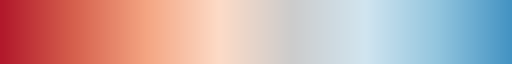

In [6]:
temp = RdBu_11.mpl_colors
temp[5] = (0.8,0.8,0.8)
# newcmp = LinearSegmentedColormap.from_list('RdBu_11',RdBu_11.mpl_colors)
newcmp = LinearSegmentedColormap.from_list('RdBu_11',temp[1:-2])
newcmp

In [7]:
def f_lifetime(E_NO,E_CO,E_VOC=0):
    return -0.456*E_NO+0.024*E_CO+0.027*E_VOC

In [8]:
E_NOX_range = For_scen.E_NOX.sum('reg_land').min().values,For_scen.E_NOX.sum('reg_land').max().values
E_CO_range = For_scen.E_CO.sum('reg_land').min().values,For_scen.E_CO.sum('reg_land').max().values

N = 200

E_NOX_list = np.linspace(0,E_NOX_range[1],N)
E_CO_list = np.linspace(0,E_CO_range[1]*1.02,N)

lifetime_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        lifetime_matrix[i,j] = f_lifetime(E_NOX_list[i],E_CO_list[j])


In [9]:
For_scen_tmp = For_scen.sel(year=slice(None, 2050)).copy(deep=True).drop_vars('D_CH4')
## 生成三个排放情景

## 2014-2019 (CEDS)
CEDS_CH4 = [270.2496358,269.8280079,267.9817751,268.1138598,270.537411,271.6083044]
CEDS_NOX = [38.59678516,37.98745474,37.48333497,37.43483474,37.16926467,36.81225668]
CEDS_CO = [247.089963,241.5313653,233.9000087,230.9691292,228.7215534,226.6449276]
CEDS_VOC = [149.9870685,148.9745692,148.276486,148.5098291,147.521796,146.6675455]

For_scen_real = For_scen_tmp.copy(deep=True).sel(scen=['SSP2-4.5','SSP2-4.5','SSP2-4.5']).assign_coords(scen=np.array(['middle','clean','polluted']))
For_scen_real.E_CH4[0,6:] -= (For_scen_real.E_CH4.sel(year=2019).sum('reg_land').values-CEDS_CH4[-1])
for i in range(len(CEDS_CH4)):
    For_scen_real.E_CH4[:,i] *=0
    For_scen_real.E_CH4[0,i] +=CEDS_CH4[i]
for var in ['E_NOX','E_CO','E_VOC',]:
    For_scen_real[var][...,1] = For_scen_tmp[var].copy(deep=True).sel(scen='SSP1-1.9')
    For_scen_real[var][...,2] = For_scen_tmp[var].copy(deep=True).sel(scen='SSP3-7.0')
For_scen_real.E_NOX[0,6:] -= (For_scen_real.E_NOX.sel(year=2019).sum('reg_land').values-CEDS_NOX[-1])
For_scen_real.E_CO[0,6:] -= (For_scen_real.E_CO.sel(year=2019).sum('reg_land').values-CEDS_CO[-1])
For_scen_real.E_VOC[0,6:] -= (For_scen_real.E_VOC.sel(year=2019).sum('reg_land').values-CEDS_VOC[-1])

for i in range(len(CEDS_CH4)):
    For_scen_real.E_NOX[:,i] *=0
    For_scen_real.E_NOX[0,i] +=CEDS_NOX[i]
    For_scen_real.E_CO[:,i] *=0
    For_scen_real.E_CO[0,i] +=CEDS_CO[i]
    For_scen_real.E_VOC[:,i] *=0
    For_scen_real.E_VOC[0,i] +=CEDS_VOC[i]

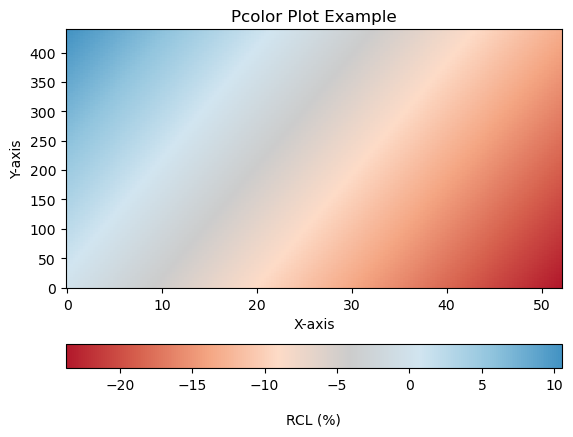

In [10]:
fig, ax = plt.subplots()
pc = ax.pcolor(E_NOX_list, E_CO_list, lifetime_matrix.T,
                cmap=newcmp)
cbar = fig.colorbar(pc, ax=ax,orientation='horizontal')
ax.set_title('Pcolor Plot Example')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
cbar.set_label('RCL (%)', rotation=0, labelpad=15)
fig.savefig('colorbar.pdf',dpi=300)

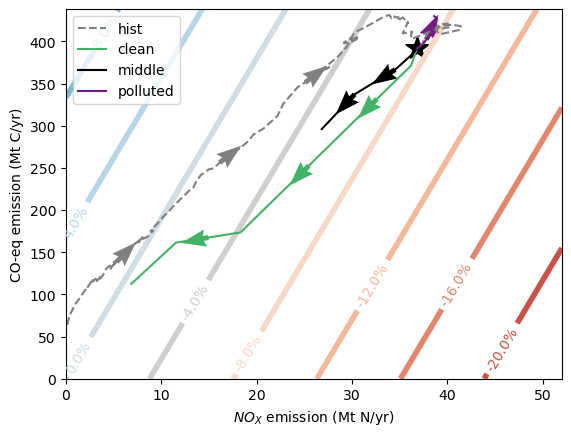

In [11]:
def fmt(x):
    s = f"{x:.1f}%"
#     if s.endswith("0"):
#         s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

fig, ax = plt.subplots()
CS = ax.contour(E_NOX_list, E_CO_list, lifetime_matrix.T,
                cmap=newcmp,
                linewidths=4,levels=10)
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
ax.set_xlabel('$NO_X$ emission (Mt N/yr)')
ax.set_ylabel('CO-eq emission (Mt C/yr)')


### 历史
df = pd.read_csv ('CEDS_data.csv')

ax.plot(df['NOX'][100:],
        (df['CO']+df['VOC']*0.027/0.024)[100:],
        color='grey',
        label='hist',linestyle='--')
i = 180
ax.quiver(df['NOX'][i],
          (df['CO']+df['VOC']*0.027/0.024)[i],
          1,1,
          color='grey', width=.01,headwidth=3.5)
i = 212
ax.quiver(df['NOX'][i],
          (df['CO']+df['VOC']*0.027/0.024)[i],
          1,0.78,
          color='grey', width=.01,headwidth=3.5)
i = 221
ax.quiver(df['NOX'][i],
          (df['CO']+df['VOC']*0.027/0.024)[i],
          1,0.75,
          color='grey', width=.01,headwidth=3.5)
### 未来情景



color_list = ['k','#41B365','#741A88']
for i in [1,0,2]:
    ax.plot(For_scen_real.E_NOX.sum('reg_land').isel(scen=i).sel(year=slice(2019,2050)),
            For_scen_real.E_CO.sum('reg_land').isel(scen=i).sel(year=slice(2019,2050))+For_scen_real.E_VOC.sum('reg_land').isel(scen=i).sel(year=slice(2019,2050))*0.027/0.024,
            color=color_list[i],
            label=For_scen_real.scen.values[i])
# ax.plot(For_scen_real.E_NOX.sum('reg_land').isel(scen=i).sel(year=slice(2014,2019)),
#         For_scen_real.E_CO.sum('reg_land').isel(scen=i).sel(year=slice(2014,2019))+For_scen_real.E_VOC.sum('reg_land').isel(scen=i).sel(year=slice(2014,2019))*0.027/0.024,
#         color='k')    

ax.scatter(For_scen_real.E_NOX.sum('reg_land').isel(scen=i).sel(year=2019),
        For_scen_real.E_CO.sum('reg_land').isel(scen=i).sel(year=2019)+For_scen_real.E_VOC.sum('reg_land').isel(scen=i).sel(year=2019)*0.027/0.024,
        color='k',marker='o',s=50) 

### 箭头
scen = 0
year = 2030
ax.quiver(For_scen_real.E_NOX.sum('reg_land').isel(scen=scen).sel(year=year),
          For_scen_real.E_CO.sum('reg_land').isel(scen=scen).sel(year=year)+For_scen_real.E_VOC.sum('reg_land').isel(scen=scen).sel(year=year)*0.027/0.024,
          -3,-1.9,
          color='k', width=.01,headwidth=3.5)
year = 2040
ax.quiver(For_scen_real.E_NOX.sum('reg_land').isel(scen=scen).sel(year=year),
          For_scen_real.E_CO.sum('reg_land').isel(scen=scen).sel(year=year)+For_scen_real.E_VOC.sum('reg_land').isel(scen=scen).sel(year=year)*0.027/0.024,
          -3,-3.2,
          color='k', width=.01,headwidth=3.5)
###########
scen = 1
year = 2022
ax.quiver(For_scen_real.E_NOX.sum('reg_land').isel(scen=scen).sel(year=year),
          For_scen_real.E_CO.sum('reg_land').isel(scen=scen).sel(year=year)+For_scen_real.E_VOC.sum('reg_land').isel(scen=scen).sel(year=year)*0.027/0.024,
          -3,-3.1,
          color='#41B365', width=.01,headwidth=3.5)
year = 2026
ax.quiver(For_scen_real.E_NOX.sum('reg_land').isel(scen=scen).sel(year=year),
          For_scen_real.E_CO.sum('reg_land').isel(scen=scen).sel(year=year)+For_scen_real.E_VOC.sum('reg_land').isel(scen=scen).sel(year=year)*0.027/0.024,
          -3,-3.1,
          color='#41B365', width=.01,headwidth=3.5)
year = 2035
ax.quiver(For_scen_real.E_NOX.sum('reg_land').isel(scen=scen).sel(year=year),
          For_scen_real.E_CO.sum('reg_land').isel(scen=scen).sel(year=year)+For_scen_real.E_VOC.sum('reg_land').isel(scen=scen).sel(year=year)*0.027/0.024,
          -5.5,-1.1,
          color='#41B365', width=.01,headwidth=3.5)
###########
scen = 2
year = 2023
ax.quiver(For_scen_real.E_NOX.sum('reg_land').isel(scen=scen).sel(year=year),
          For_scen_real.E_CO.sum('reg_land').isel(scen=scen).sel(year=year)+For_scen_real.E_VOC.sum('reg_land').isel(scen=scen).sel(year=year)*0.027/0.024,
          1,2.1,
          color='#741A88', width=.01,headwidth=3.5)


ax.scatter(For_scen_real.E_NOX.sum('reg_land').isel(scen=0).sel(year=2019),
          For_scen_real.E_CO.sum('reg_land').isel(scen=0).sel(year=2019)+For_scen_real.E_VOC.sum('reg_land').isel(scen=0).sel(year=2019)*0.027/0.024,
          color='k',
          marker='*',s=300)
ax.legend()

# ax.set_title('Relative change in $CH_4$ lifetime induced by pollutants RCL')
fig.savefig('等值线图.pdf',dpi=300)

Fig.2b 理想实验

甲烷排放恒定不变的情况下lifetime是怎么变的？

In [16]:
from core_fct.mod_process import OSCAR
from core_fct.fct_loadP import load_all_param
from core_fct.fct_genMC import generate_config
from run_scripts.get_SSP_drivers import For_hist
from run_scripts.get_SSP_drivers import For_scen

In [17]:
For_scen_ideal = For_scen_real.sel(year=slice(2014,2050)).copy(deep=True)

In [18]:
Par0 = load_all_param(mod_region='RCP_5reg')
Par = generate_config(Par0, nMC=200)
Par = xr.merge([Par, For_hist.drop([VAR for VAR in For_hist if 'year' in For_hist[VAR].dims])])
For_hist = For_hist.drop([VAR for VAR in For_hist if 'year' not in For_hist[VAR].dims])

var_keep = ['D_Eluc', 'D_Focean', 'D_Fland', 'D_Epf'] + ['tau_CH4', 'tau_N2O'] + ['RF_CH4','RF_O3t']+['D_O3t']+['f_kOH_O3P']
Out_hist = OSCAR(Ini=None, Par=Par, For=For_hist, var_keep=var_keep+['f_kOH','f_kOH_O3P', 'D_Ebb','f_hv','D_Ewet','D_Epf_CH4','D_O3s','D_Ta', 'D_f_Qa'])

loading primary parameters
generating MC configurations
OSCAR_v3 running
year = 2014 (nt = 3)
total running time: 5.0 minutes


In [19]:
Ini = Out_hist.isel(year=-1, drop=True)
Ini['D_CH4'] = 1822.61-Par0.CH4_0 # https://gml.noaa.gov/webdata/ccgg/trends/ch4/ch4_annmean_gl.txt

For_scen_tmp = For_scen.sel(year=slice(None, 2050)).copy(deep=True).drop_vars('D_CH4')

x2_OH_NOX = 0.00456
x2_OH_CO = -0.00024
x2_OH_VOC = -0.00027

Par_tmp = Par.copy(deep=True)
Par_tmp.kOH_is_Log.values = np.array([False]*200)
Par_tmp.x2_OH_NOX.values = np.array([x2_OH_NOX]*200)
Par_tmp.x2_OH_CO.values = np.array([x2_OH_CO]*200)
Par_tmp.x2_OH_VOC.values = np.array(x2_OH_VOC)

Par_tmp['t_OH_CH4'] = 11.2

In [20]:
for year in np.arange(2014,2050+1):
#     print(year)
    pass
    if year >= 2020:
        For_scen_ideal.E_CH4[:,year-2014,:] = For_scen_ideal.E_CH4[:,2019-2014,:]

In [21]:
Out_scen_ideal = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_ideal, var_keep=var_keep, nt=4)

OSCAR_v3 running
year = 2050 (nt = 4)
total running time: 1.6 minutes


In [23]:
x = Out_scen_ideal.year.values
y1 = f_lifetime(For_scen_ideal.E_NOX.sum('reg_land'),For_scen_ideal.E_CO.sum('reg_land'),For_scen_ideal.E_VOC.sum('reg_land')).values  #fo3p
y2 = Out_scen_ideal.tau_CH4.mean('config').values # tau
y3 = (Out_scen_ideal.D_CH4.mean('config')+Par0.CH4_0).values # CH4


-5.129946992852316
-0.4263302233336135
-7.2856988052686305


Text(0, 0.5, 'Lifetime (yr)')

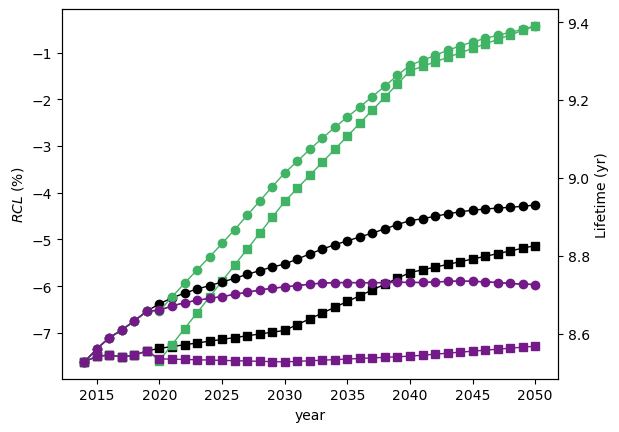

In [30]:
linestyle_list = ['-',':','--']

color_list = ['#2071aa','#ee7b21','#309738']
color_list = ['k','#41B365','#741A88']
markersize = 6
linewidth = 1

fig, ax01 = plt.subplots()

ax02 = ax01.twinx()

h0 = ax02.plot(x,y2[:,i],linewidth=linewidth,color=color_list[2],linestyle='-'#,linestyle=linestyle_list[i],
              ,marker=marker_list[i],markersize=markersize,
              label='Lifetime')


for i in [0,1,2]:
    h2 = ax01.plot(x,y1[:,i],linewidth=linewidth,color=color_list[i],linestyle='-'#,linestyle=linestyle_list[i],
                  ,marker='s',markersize=markersize,
                  label='middel')
    print(y1[:,i][-1])
    h3 = ax02.plot(x,y2[:,i],linewidth=linewidth,color=color_list[i],linestyle='-'#,linestyle=linestyle_list[i],
                  ,marker='o',markersize=markersize,
                  label='clean')
ax01.set_xlabel('year')
# ax01.set_ylabel('$CH_4$ (ppb)')
ax01.set_ylabel('$RCL$ (%)')
ax02.set_ylabel('Lifetime (yr)')


# fig.savefig('理想实验-legend.pdf',dpi=600, bbox_inches='tight')